<a href="https://colab.research.google.com/github/GavriYadlin97/SoftMax-Regression/blob/main/ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculating the Gradient of the given Softmax cost function:
\begin{align}
\nabla_{w_k} E_{in}(w) &= \frac{\partial E_{in}(w)}{\partial w_k} \\
&= \frac{\partial}{\partial w_k} \left( -\sum_{n=1}^N \sum_{j=1}^K 1\{y_n=k\} \log\left(\frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}}\right) \right) \\
&= -\sum_{n=1}^N 1\{y_n=k\} \frac{\partial}{\partial w_k} \left( \log\left(\frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}}\right) \right) \\
&= -\sum_{n=1}^N 1\{y_n=k\} \left( \frac{\sum_j e^{w_j^T x_n}}{e^{w_k^T x_n}} \right) \frac{\partial}{\partial w_k} \left( \frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}} \right)
\end{align}

\begin{align}
\frac{\partial}{\partial w_k} \left( \frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}} \right) &= \frac{x_n \cdot e^{w_k^T x_n} \left( \sum_j e^{w_j^T x_n} - x_n \cdot e^{w_k^T x_n} \right)}{\left(\sum_j e^{w_j^T x_n}\right)^2}
\end{align}

\begin{align}
\nabla_{w_k} E_{in}(w) &= -\sum_{n=1}^N 1\{y_n=k\} \frac{\left(\sum_j e^{w_j^T x_n}\right)}{\left(e^{w_k^T x_n}\right)} x_n \left( \frac{\left(\sum_j e^{w_j^T x_n}\right) - x_n e^{w_k^T x_n}}{\left(\sum_j e^{w_j^T x_n}\right)^2} \right) \\
&= -\sum_{n=1}^N 1\{y_n=k\} x_n \left( 1 - \frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}} \right)
\end{align}

Using the Gradient descend mathod, given that the update rule is:
\begin{align*}
\hat{w}(t+1) = \hat{w}(t) + \eta_t \hat{v}_t = \hat{w}(t) + \eta \nabla_{w} E_{in}(\hat{w}(t))
\end{align*}

We can insert the calculated $\nabla_{w} E_{in}$ so:
\begin{align*}
\hat{w}(t+1) = \hat{w}(t) - \eta \sum_{n=1}^N 1\{y_n=k\} x_n \left( 1 - \frac{e^{w_k^T x_n}}{\sum_j e^{w_j^T x_n}} \right)
\end{align*}


In [ ]:
# Fetch mnist
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from tabulate import tabulate
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Split data to training and testing.
X, y = mnist['data'], mnist['target']
y = y.astype(int)
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=1 / 7, shuffle=True)

# Add a bias term to input data.
XTrain = np.c_[XTrain, np.ones(XTrain.shape[0])]
XTest = np.c_[XTest, np.ones(XTest.shape[0])]

# Normalize input data
XTrain = normalize(XTrain, axis=1, norm='l2')
XTest = normalize(XTest, axis=1, norm='l2')

def one_hot_encode(labels, num_classes):
    if isinstance(labels, pd.Series):
        labels = labels.to_numpy()
    num_samples = len(labels)
    one_hot_matrix = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_matrix[i, labels[i]] = 1
    return one_hot_matrix

num_classes = 10
Y_train_one_hot = one_hot_encode(yTrain, num_classes)
Y_test_one_hot = one_hot_encode(yTest, num_classes)

Training: 100%|██████████| 2500/2500 [13:43<00:00,  3.04epoch/s]


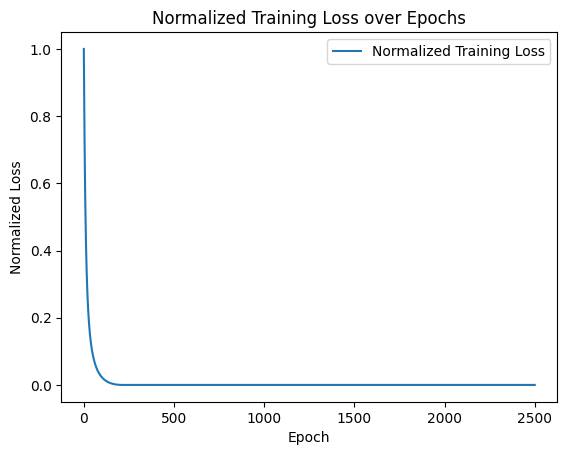

In [ ]:
def softmax(x, W_hat):
    logits = np.dot(W_hat.T, x)
    max_logit = np.max(logits, axis=0, keepdims=True)
    exp_x = np.exp(logits - max_logit)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

def loss(W_hat, X, Y):
    epsilon = 1e-10  # for numerical stability
    N = X.shape[0]

    # Compute logits for each class and each example
    logits = np.dot(W_hat.T, X.T)

    # Find the index of the true class for each example
    true_class_indices = np.argmax(Y, axis=1)

    # Obtain normalized probabilities
    softmax_probs = np.exp(logits[true_class_indices, np.arange(N)]) \
      / np.sum(np.exp(logits), axis=0, keepdims=True)

    # Select the probabilities corresponding to the true class indices, add epsilon for numerical stability
    return -np.sum(np.log(softmax_probs + epsilon), axis=1)

def gradient(W_hat, X, Y):
    logits = np.dot(W_hat.T, X.T)

    # Calculate stable softmax_probs
    max_logits = np.max(logits, axis=0, keepdims=True)
    exp_logits = np.exp(logits - max_logits)
    softmax_probs = 1 - exp_logits / np.sum(exp_logits, axis=0, keepdims=True)

    # Element-wise multiplication and summation
    result_vector = np.sum(Y * softmax_probs.T, axis=1)

    # Element-wise multiplication with broadcasting
    result_matrix = X * result_vector[:, np.newaxis]

    # Transpose and dot product
    return -np.dot(result_matrix.T, Y)

def gradient_descent(X, Y, W_init, learning_rate, num_epochs):
    W = W_init.copy()
    losses = []

    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        # Compute the gradient
        grad = gradient(W, X, Y)

        # Update parameters
        W -= learning_rate * grad

        # Compute and print the loss
        loss_val = loss(W, X, Y)
        if len(losses) > 0 and losses[-1] < loss_val:
            learning_rate /= 10
        losses.append(loss_val)

    # Normalize losses to be between 0 and 1
    min_loss, max_loss = min(losses), max(losses)
    normalized_losses = [(loss - min_loss) / (max_loss - min_loss) for loss in losses]

    # Plot the normalized loss over epochs
    plt.plot(range(1, len(losses) + 1), normalized_losses, label='Normalized Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Loss')
    plt.title('Normalized Training Loss over Epochs')
    plt.legend()
    plt.show()

    return W

# Train the model using gradient descent
num_epochs = 2500
learning_rate = 0.0002
input_size = XTrain.shape[1]
W_init = np.zeros((input_size, num_classes))
W_trained = gradient_descent(XTrain, Y_train_one_hot, W_init, learning_rate, num_epochs)

Test Accuracy: 84.93%


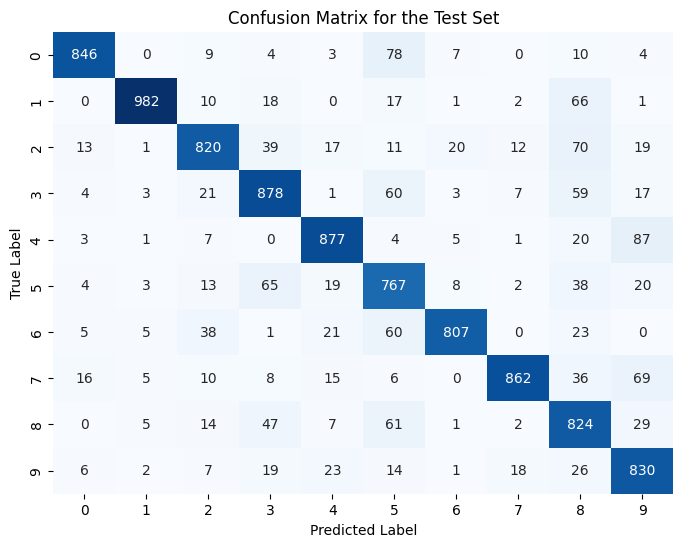


+-------+----------+--------------------+--------------------+
| Digit | Accuracy | Sensitivity (TPR)  | Selectivity (TNR)  |
+-------+----------+--------------------+--------------------+
|   0   |  0.9834  | 0.8803329864724245 | 0.9943577829405907 |
|   1   |  0.986   | 0.8951686417502279 | 0.9971919577670448 |
|   2   |  0.9669  | 0.8023483365949119 | 0.985631543773669  |
|   3   |  0.9624  | 0.8338081671415005 | 0.9775343690622555 |
|   4   |  0.9766  | 0.872636815920398  | 0.9882156753752085 |
|   5   |  0.9517  | 0.8168264110756124 | 0.9656770775852555 |
|   6   |  0.9801  |      0.840625      | 0.9949115044247787 |
|   7   |  0.9791  | 0.8393378773125608 | 0.9950964003120473 |
|   8   |  0.9486  | 0.8323232323232324 | 0.9613762486126526 |
|   9   |  0.9638  | 0.8773784355179705 | 0.9728296885354539 |
+-------+----------+--------------------+--------------------+
Average Test Set Accuracy: 96.99%


In [ ]:
# Make predictions on the test set using softmax probabilities
def predict(W, X):
    logits = np.dot(W.T, X.T)
    softmax_probs = np.exp(logits - np.max(logits, axis=0, keepdims=True)) / np.sum(np.exp(logits), axis=0, keepdims=True)
    return softmax_probs.T

# Make predictions on the test set
y_pred_probs = predict(W_trained, XTest)

# Convert softmax probabilities to predicted labels
y_pred_original = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = np.sum(y_pred_original == yTest) / len(yTest)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(yTest, y_pred_original)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for the Test Set')
plt.show()

# Display metrics for the entire test set
table_headers = ["Digit", "Accuracy", "Sensitivity (TPR)", "Selectivity (TNR)"]
table_data = []
total_set_acc = 0
for digit in range(10):
    TP = conf_matrix[digit, digit]
    TN = np.sum(np.delete(np.delete(conf_matrix, digit, axis=0), digit, axis=1))
    FP = np.sum(conf_matrix[:, digit]) - TP
    FN = np.sum(conf_matrix[digit, :]) - TP

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    sensitivity = TP / max(TP + FN, 0)
    selectivity = TN / max(TN + FP, 0)
    total_set_acc += accuracy

    table_data.append([digit, accuracy, sensitivity, selectivity])

# Display metrics in a table
print()
print(tabulate(table_data, headers=table_headers, tablefmt="pretty"))
print(f"Average Test Set Accuracy: {total_set_acc * 10:.2f}%")

The model shows high accuracy for most digits, with an average test set accuracy of approx 95%. and total test accuracy of approx 83%
Sensitivity varies across digits, with digits 0, 1, and 9 having relatively high values, indicating effective identification of these digits.
Selectivity is also high for most digits, suggesting the model's ability to distinguish the evaluated digit from others.

According to the confusion matrix, it seems the model mostly struggles with identifying the digits 5 and 8.

Also, according to the Training loss, the model seems to be doing very well in the first epochs, then slowing down and increasing the accuracy more subtly over later epochs.

The implementation of the model in a vectorized mannar is easier, contributing to faster calculation, and more efficent learning (in terms of time and memory usage)